In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
#stuff to import

In [2]:
#the dataset
earthquake_data = pd.read_csv("Japan earthquakes 2001 - 2018.csv")

Accuracy: 0.882937211777226


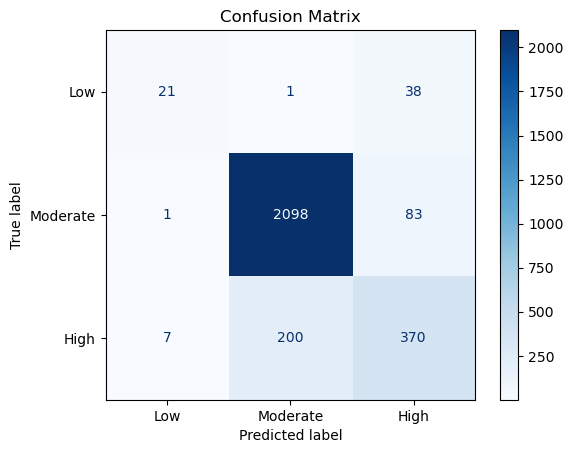

In [3]:
# Feature engineering for the 'time' column- this doesn't seem to improve accuracy this time around, so I commented it out
'''earthquake_data['year'] = pd.to_datetime(earthquake_data['time']).dt.year
earthquake_data['month'] = pd.to_datetime(earthquake_data['time']).dt.month
earthquake_data['day'] = pd.to_datetime(earthquake_data['time']).dt.day
earthquake_data['hour'] = pd.to_datetime(earthquake_data['time']).dt.hour'''

irrelevant_cols = ['id', 'updated', 'place', 'locationSource', 'magSource', 'time']
data_cleaned = earthquake_data.drop(columns=irrelevant_cols)

# we want to categorize magnitude into three categories, low/Med/High
def categorize_magnitude(magnitude):
    if 4.0 <= magnitude < 5.0:
        return 'Low'
    elif 5.0 <= magnitude < 6.0:
        return 'Moderate'
    elif magnitude >= 6.0:
        return 'High'

data_cleaned['mag_category'] = data_cleaned['mag'].apply(categorize_magnitude)

X = data_cleaned.drop(columns=['mag', 'mag_category'])
y = data_cleaned['mag_category']

#lots of stuff similar to RandomForests
numerical_cols = X.select_dtypes(include=['float64', 'int']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

#preprocessors
num_transformer = SimpleImputer(strategy='median')
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ],
    remainder='drop'
)

#The model- 10,000 iterations improves accuracy and prevents errors it seems
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000, random_state=42) #multinomial and lbfgs should be the default setting but I'll set them anyway

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', logreg)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

#stats for nerds
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=['Low', 'Moderate', 'High'], cmap='Blues')
plt.title("Confusion Matrix")
plt.show()